# Import Library 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import time
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
def rand(random_seed = 777):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

# Parameter 

In [3]:
device = torch.device("cuda:4" if (torch.cuda.is_available()) else "cpu")

dataset_dir = './Dataset/'
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
class_num = 3
num_workers = 0

input_channel = 3
channel = 64
batch_size = 1
num_epochs = 20
lr_D = 0.0004
lr_G = 0.0001
alpha = 10
beta = 1

save_dir = './CheckPoint'

# Utils 

### DataLoader

In [4]:
class YouTubePose(Dataset):
    def __init__(self, dataset_dir, class_num, transform = None):
        self.dataset_dir = dataset_dir
        self.class_num = class_num
        self.transform = transform
          
    def __len__(self):
        length = []
        for i in range(self.class_num):
            dir_path = self.dataset_dir +'train/class{}_cropped'.format(i + 1)
            length.append(len(os.walk(dir_path).__next__()[2]))
        max_len = max(length)
        return max_len
    
    def _rand(self):
        randx = random.randint(1,self.class_num)
        randy = randx
        while(randx == randy): #같을 때만, 수행 즉 다를 때까지 수행
            randy = random.randint(1,self.class_num)
        return randx, randy
    
    def __getitem__(self, idx):
        randx, randy = self._rand()
        x = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randx)))
        y = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randy)))
        x_hat = x
        while(x_hat == x):
            x_hat = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randx)))
            
        identity_equal_1 = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randx)))
        identity_equal_2 = identity_equal_1
        while(identity_equal_1 == identity_equal_2):
            identity_equal_2 = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randx)))
            
        x = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                       .format(randx)+ x)
        y = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                       .format(randy)+ y)
        x_hat = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                           .format(randx)+ x_hat)
        
        identity_equal_1 = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                                      .format(randx)+ identity_equal_1)
        identity_equal_2 = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                                      .format(randx)+ identity_equal_2)
        
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
            x_hat = self.transform(x_hat)
            identity_equal_1 = self.transform(identity_equal_1)
            identity_equal_2 = self.transform(identity_equal_2)
       
        sample = {'x' : x, 'y' : y, 'x_hat' : x_hat, 
                 'identity_equal_1' : identity_equal_1, 
                 'identity_equal_2' : identity_equal_2}
        
        return sample

### Loss

In [5]:
def Iden_loss(real_pair, fake_pair):
    batch_size = real_pair.size()[0]
    real_pair = 1 - real_pair
    real_pair = torch.sqrt(real_pair ** 2)
    fake_pair = torch.sqrt(fake_pair ** 2)
    real_pair = torch.sum(real_pair)
    fake_pair = torch.sum(fake_pair)
    Iden_loss = (real_pair + fake_pair) / batch_size
    
    return Iden_loss

def Shape_loss(Input, target):
    batch_size = Input.size()[0]
    Shape_loss = torch.abs(target - Input)
    Shape_loss = torch.sum(Shape_loss) / batch_size
    
    return Shape_loss

### Weights Initialization 

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    if classname.find('Conv') != -1:
        nn.utils.spectral_norm(m)

# Model

### Residualblock 

In [7]:
def conv3x3(in_channels, out_channels, stride = 1, padding = 1,
           padding_mode = 'zeros'):
    return nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                    stride = stride, padding = padding, padding_mode = padding_mode)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, padding = 1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        #conv3x3을 정의해서 쓰면 nn.Sequential로 정리 못하는가?
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual
        #out = self.relu(out) 
        #Clova code 에선 relu 통과x
        return out

### Generator 

In [8]:
class Generator(nn.Module):
    def __init__(self, resblock, padding_mode = 'zeros'):
        super(Generator, self).__init__()
        
        self.x_conv1 = nn.Sequential(
            nn.Conv2d(input_channel, channel, 7, 1, 3, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        self.y_conv1 = nn.Sequential(
            nn.Conv2d(input_channel, channel, 7, 1, 3, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        
        self.x_conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        self.y_conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        
        self.x_conv3 = nn.Sequential(
            nn.Conv2d(channel * 2, channel * 4, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.ReLU(),
        )
        self.y_conv3 = nn.Sequential(
            nn.Conv2d(channel * 2, channel * 4, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.ReLU(),
        )
        
        self.x_resblock = resblock(channel * 4, channel * 4)
        self.y_resblock = resblock(channel * 4, channel * 4)
        
        self.resblock = resblock(channel * 4, channel * 4)
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(channel * 4, channel * 2, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(channel * 2, channel, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(channel, input_channel, 7, 1, 3, padding_mode = padding_mode),
            nn.Tanh(),
        )

    def forward(self, x, y):
        x_out = self.x_conv1(x) #size는 그대로 channel만 두배
        x_out = self.x_conv2(x_out) #size 1/2배 channel 두배
        x_out1 = x_out
        x_out = self.x_conv3(x_out)
        x_out2 = x_out
        x_out = self.x_resblock(x_out)
        x_out = self.x_resblock(x_out)
        
        y_out = self.y_conv1(y)
        y_out = self.y_conv2(y_out)
        y_out1 = y_out
        y_out = self.y_conv3(y_out)
        y_out2 = y_out
        y_out = self.y_resblock(y_out)
        y_out = self.y_resblock(y_out)
        
        #out = torch.cat([x_out, y_out], dim = 1) #channel 차원에 concat
        out = x_out + y_out
        out = self.resblock(out)
        out = self.resblock(out)
        
        #Shortcut resblock도 넣어보기.
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        return out

### Discriminator

In [9]:
class Discriminator(nn.Module): #batch Norm 사용 안하면? 어떨까
    def __init__(self, padding_mode = 'zeros'):
        super(Discriminator, self).__init__()
                
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel * 2, channel, 4, 2, 1, padding_mode = padding_mode),
            nn.LeakyReLU(0.2),
        )
        #4, 2, 1 이면 input image size의 절반이 output image size
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channel * 2, channel * 4, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channel * 4, channel * 4, 3, 1, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channel * 4, channel * 4, 3, 1, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channel * 4, 1, 3, 1, 1, padding_mode = padding_mode),
        )
        
        self.maxpool = nn.MaxPool2d(8)
    
    def forward(self, x, y):
        xy = torch.cat([x,y], dim = 1)
        out = self.conv1(xy)
        out = self.conv2(out)
        out = self.conv3(out)
        out_neg = -out
        out_pooled = self.maxpool(out_neg)
        out_pooled = -out_pooled #Min-Patch
        
        return out, out_pooled

### Visualize datasets 

In [10]:
train_dataset = YouTubePose(dataset_dir, class_num, transform)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                             shuffle = True, num_workers = num_workers)

generator = Generator(ResidualBlock).to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr = lr_G, betas = (0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr_D, betas = (0.5, 0.999))

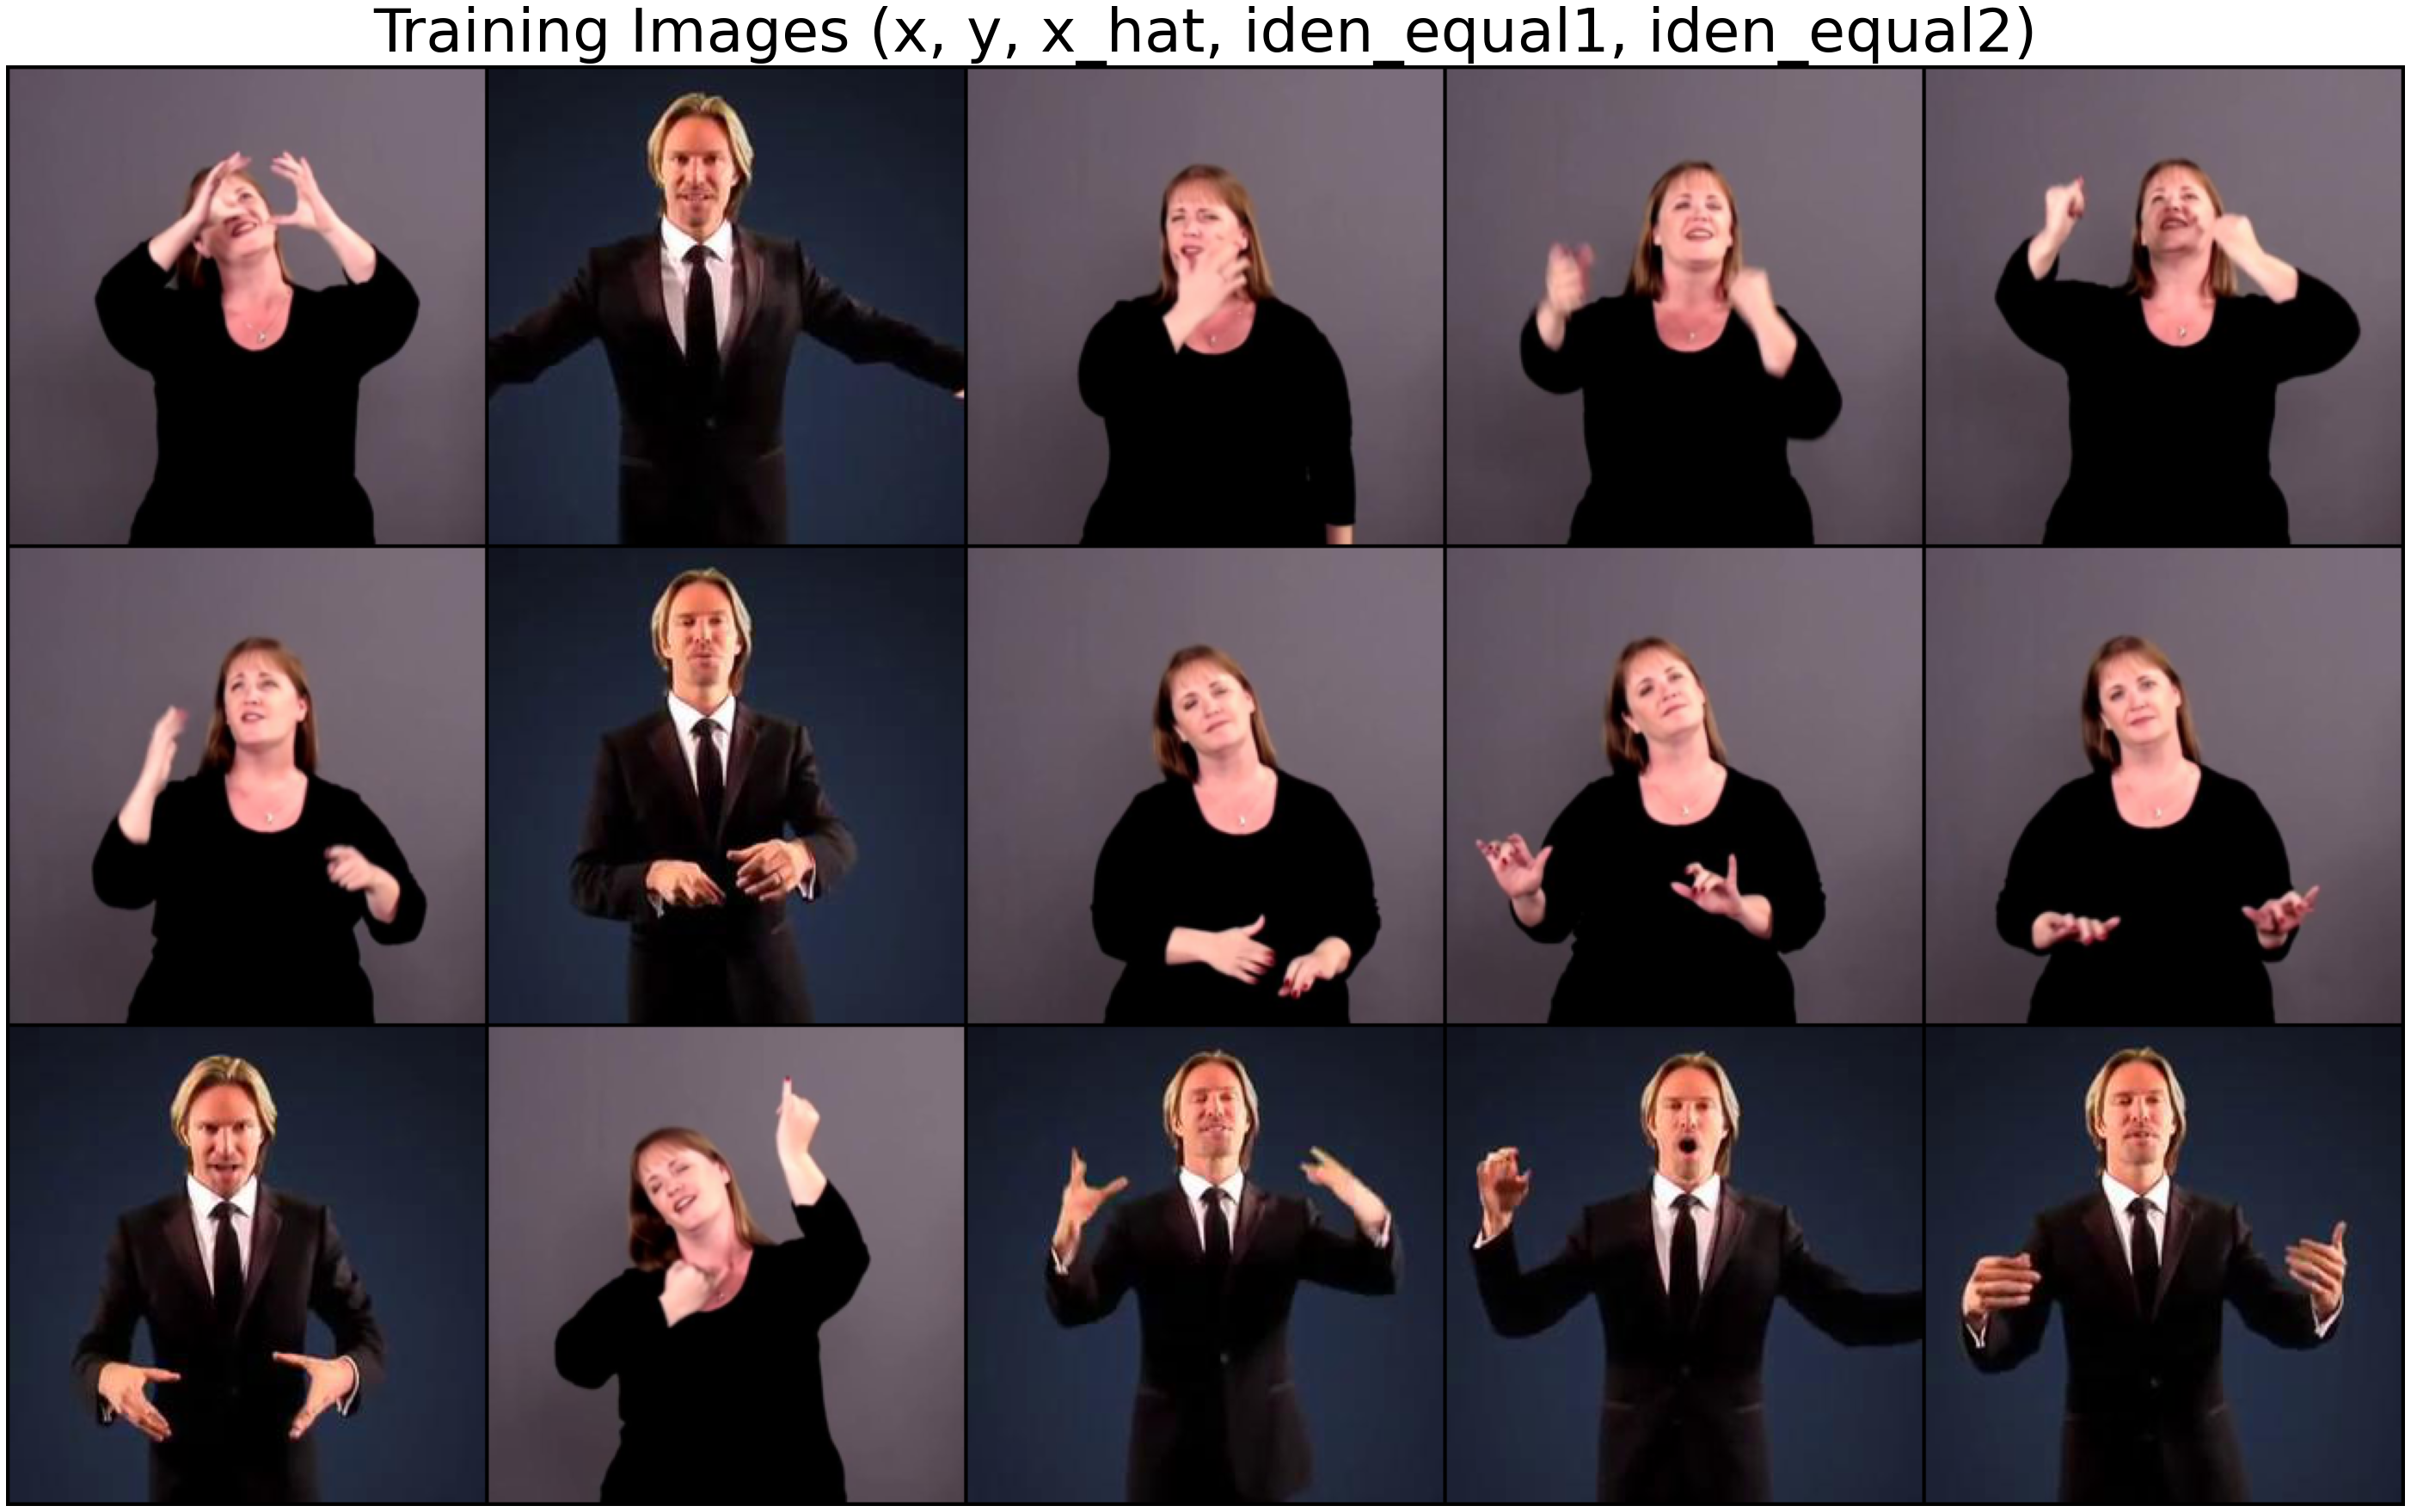

In [11]:
sample_list = []
for i in range(3):
    sample = next(iter(train_dataloader))
    sample_list.extend([sample['x'][0], sample['y'][0], sample['x_hat'][0], sample['identity_equal_1'][0], sample['identity_equal_2'][0]])

plt.figure(figsize=(50,50))
plt.axis('off')
plt.title('Training Images (x, y, x_hat, iden_equal1, iden_equal2)', size = 70)
plt.imshow(np.transpose(utils.make_grid(sample_list, padding = 2,
                                       normalize = True, nrow = 5),(1,2,0)))

# Training 

In [12]:
def save_checkpoint(state, dirpath, epoch):
    filename = 'checkpoint-{}.pt'.format(epoch)
    checkpoint_path = os.path.join(dirpath, filename)
    torch.save(state, checkpoint_path)
    print('--- checkpoint saved to ' + str(checkpoint_path) + ' ---')

In [13]:
generator = Generator(ResidualBlock).to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr = lr_G, betas = (0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr_D, betas = (0.5, 0.999))

In [14]:
for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    print('-' * 10)
    
    dataloader = train_dataloader
    netG = generator
    netG.train()
    netD = discriminator
    netD.train()
    start = time.time()
    
    LI_list = []
    Ls_list = []
    
    for i, sample in enumerate(dataloader, 0): #start = 0
        x, y, x_hat = sample['x'], sample['y'], sample['x_hat']
        iden_equal1 = sample['identity_equal_1']
        iden_equal2 = sample['identity_equal_2']
        batch_size = x.size(0)
        x = x.to(device)
        y = y.to(device)
        x_hat = x_hat.to(device)
        iden_equal1 = iden_equal1.to(device)
        iden_equal2 = iden_equal2.to(device)
        
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        
        #Ix != Iy
        #Update G with maximize LI & Min-Patch Training
        output = netG(x, y)
        fake, fake_pooled = netD(x, output)
        real, real_pooled = netD(x, x_hat)
        LI = -Iden_loss(real_pooled, fake_pooled) #maximize LI
        LI_list.append(LI)
        LI.backward(retain_graph=True) #역전파 두번 사용시 필요
        optimizer_G.step()
        
        #Update D with minimize LI
        optimizer_D.zero_grad()
        LI = Iden_loss(real, fake)
        LI_list.append(LI)
        LI.backward(retain_graph=True)
        optimizer_D.step()
        
        #Update G with minimize Ls2a, Ls2b
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        output_ls2a = netG(y, output)
        output_ls2b = netG(output, y)
                
        Ls2a = Shape_loss(y, output_ls2a)
        Ls2b = Shape_loss(output, output_ls2b)
        Ls2 = Ls2a + Ls2b
        Ls_list.append(Ls2)
        
        Ls2.backward()
        optimizer_G.step()
        
        #Ix == Iy
        #Update G with Ls1
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        
        output_ls1 = netG(iden_equal1, iden_equal2)
        
        Ls1 = Shape_loss(iden_equal2, output_ls1)
        Ls_list.append(Ls1)
        
        Ls1.backward()
        optimizer_G.step()
        
        if (i % 1000 == 0):
            print("[{:d}/{:d}] [{:d}/{:d}] LI:{:.4f} Ls1:{:.4f} Ls2a:{:.4f} Ls2b:{:.4f}".
         format(epoch, num_epochs, i, len(dataloader), LI, Ls1, Ls2a, Ls2b))
    print("="*10)
    print("[{:d}/{:d}] LI:{:.4f} Ls:{:.4f}".format(epoch, num_epochs, 
                                                   sum(LI) / len(LI), sum(Ls) / len(L2)))
print("Training is finished")

Epoch 1/20
----------
[0/20] [0/8260] LI:352959.1875 Ls1:148552.4062 Ls2a:121450.8281 Ls2b:61127.7930


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 4; 10.76 GiB total capacity; 9.48 GiB already allocated; 10.19 MiB free; 9.59 GiB reserved in total by PyTorch)